### Examine the Data

In [85]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import statsmodels.api as sm

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")



In [86]:

# Read the dataset
df_raw = pd.read_csv('stuckat0_training.csv', index_col=0, header=0, parse_dates=True)
df_raw.index.freq = 'MS'

df_raw.head()


Tank1WaterLevel  Tank2WaterLevel  Tank1InFlow  Tank2OutFlow  wt3_valve  \
time                                                                           
0.00     1.000000e-06     0.000000e+00            0           0.0          0   
0.05     6.890000e-07     3.110000e-07            0           0.0          0   
0.10     3.333928e-03     4.050000e-07            1           0.0          0   
0.15     5.448433e-02     8.850002e-03            1           0.0          0   
0.20     7.717051e-02     2.949715e-02            0           0.0          0   

      Tank3OutFlow  Tank2.level  
time                             
0.00           0.0          0.0  
0.05           0.0          0.0  
0.10           0.0          0.0  
0.15           0.0          0.0  
0.20           0.0          0.0

In [87]:
df_raw.isna().sum()

Tank1WaterLevel    0
Tank2WaterLevel    0
Tank1InFlow        0
Tank2OutFlow       0
wt3_valve          0
Tank3OutFlow       0
Tank2.level        0
dtype: int64

### Plot the source data

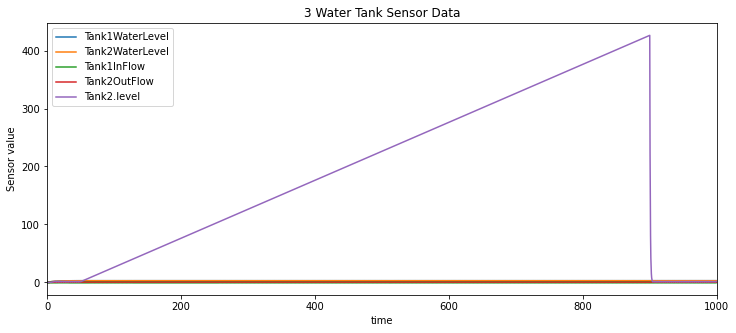

In [88]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df_raw['Tank1WaterLevel'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df_raw['Tank2WaterLevel'].plot(legend=True)
df_raw['Tank1InFlow'].plot(legend=True)
df_raw['Tank2OutFlow'].plot(legend=True)
# df['wt3_valve'].plot(legend=True)
# df['Tank3OutFlow'].plot(legend=True)
df_raw['Tank2.level'].plot(legend=True)
plt.show()

In [89]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [90]:
adf_test(df_raw['Tank1WaterLevel'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.255233e+01
p-value                 2.192107e-23
#lags                   4.600000e+01
#observations           1.995400e+04
critical value (1%)    -3.430678e+00
critical value (5%)    -2.861685e+00
critical value (10%)   -2.566847e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [91]:
# All the correlated features are stationary.
df_raw.head()

Tank1WaterLevel  Tank2WaterLevel  Tank1InFlow  Tank2OutFlow  wt3_valve  \
time                                                                           
0.00     1.000000e-06     0.000000e+00            0           0.0          0   
0.05     6.890000e-07     3.110000e-07            0           0.0          0   
0.10     3.333928e-03     4.050000e-07            1           0.0          0   
0.15     5.448433e-02     8.850002e-03            1           0.0          0   
0.20     7.717051e-02     2.949715e-02            0           0.0          0   

      Tank3OutFlow  Tank2.level  
time                             
0.00           0.0          0.0  
0.05           0.0          0.0  
0.10           0.0          0.0  
0.15           0.0          0.0  
0.20           0.0          0.0

### Normalisation of the dataset

In [92]:
# Read the mean and std used for normalising the golden model
var_df = pd.read_csv("norm_var.csv", index_col=0)
old_means, old_stds = var_df["0"], var_df["1"]

def normalise_series(data, means, stds):
    normalised_data = (data - means) / stds
    return pd.DataFrame(normalised_data)


def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)


normalised_data = normalise_series(df_raw, old_means, old_stds)

In [93]:
df = normalised_data

In [94]:
# Train Test Split
nobs = 3000
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(17001, 3000)

### VAR Model Order Selection

In [95]:
# from statsmodels.tsa.vector_ar.var_model import VAROrderSelection
# Perform order selection using auto-arima
model = VAR(train)
# Select the best order based on a specific criterion (e.g. AIC, BIC)
selected_order = model.select_order()
# Get the selected order (lag length)
order = selected_order.selected_orders['aic']
min_aic_index = order
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))

Order 43 has the least AIC value. Let us select p = 43 in the modelling


In [96]:
# p = [1,2,3,4,5,6,7] # try with list of 7 p values
# p = list(range(1,20))
# aic, bic = [], []
# for i in p:
#     model = VAR(train)
#     results = model.fit(i)
#     aic.append(results.aic)
#     bic.append(results.bic)
#     print(f'VAR Order {i}')
#     print('AIC: {}'.format(results.aic))
#     print('BIC: {}'.format(results.bic))
#     print()

# min_aic = min(aic)
# min_aic_index = aic.index(min_aic) + 1
# min_bic = min(bic)
# min_bic_index = bic.index(min_bic) + 1
# print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


In [97]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank1WaterLevel',
 'Tank2WaterLevel',
 'Tank1InFlow',
 'Tank2OutFlow',
 'wt3_valve',
 'Tank3OutFlow',
 'Tank2.level']

### Fit the VAR {{min_aic_index}}  model

In [98]:
min_aic_index

43

In [99]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Jul, 2023
Time:                     22:22:46
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -79.0425
Nobs:                     16958.0    HQIC:                  -79.6890
Log likelihood:           512059.    FPE:                1.79194e-35
AIC:                     -80.0072    Det(Omega_mle):     1.58366e-35
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.010923         0.000277          -39.438           0.000
L1.Tank1WaterLevel          0.264345         0.009397           28.130           0.000
L1.Tank2WaterLevel        

### Predict the next 20 values

In [100]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

43

In [101]:
df.head()

Tank1WaterLevel  Tank2WaterLevel  Tank1InFlow  Tank2OutFlow  wt3_valve  \
time                                                                           
0.00       -13.751169       -13.647795    -1.001251    -11.718138   -0.58372   
0.05       -13.751171       -13.647793    -1.001251    -11.718138   -0.58372   
0.10       -13.736104       -13.647793     0.998751    -11.718138   -0.58372   
0.15       -13.504895       -13.607095     0.998751    -11.718138   -0.58372   
0.20       -13.402350       -13.512143    -1.001251    -11.718138   -0.58372   

      Tank3OutFlow  Tank2.level  
time                             
0.00     -0.563189    -4.102034  
0.05     -0.563189    -4.102034  
0.10     -0.563189    -4.102034  
0.15     -0.563189    -4.102034  
0.20     -0.563189    -4.102034

In [102]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values[-lag_order:], steps=steps)
z

array([[ 1.65432957e-01,  1.23572776e-01,  9.98239776e-01,
         1.26505933e-01, -5.87837465e-01, -5.62783410e-01,
         1.13218026e+03],
       [ 2.70709832e-01,  1.54667925e-01,  9.97297150e-01,
         1.44200180e-01, -5.88418128e-01, -5.68575772e-01,
         1.13226550e+03],
       [ 1.75718708e-01,  1.74578841e-01, -1.00208630e+00,
         1.69784053e-01, -5.94020760e-01, -5.70310378e-01,
         1.13232310e+03],
       [ 5.75569668e-02,  1.56492965e-01, -1.00074162e+00,
         1.68286614e-01, -5.95808065e-01, -5.76835810e-01,
         1.13240954e+03],
       [ 6.90195486e-02,  1.29564988e-01,  9.99788346e-01,
         1.43795480e-01, -5.99213064e-01, -5.77923203e-01,
         1.13246833e+03],
       [ 2.04501131e-01,  1.30113697e-01,  1.00008389e+00,
         1.27328562e-01, -5.99125719e-01, -5.82138656e-01,
         1.13255520e+03],
       [ 2.70572066e-01,  1.54733181e-01,  9.88176729e-01,
         1.44257298e-01, -6.03016998e-01, -5.81613207e-01,
         1.1326143

In [103]:
test

Tank1WaterLevel  Tank2WaterLevel  Tank1InFlow  Tank2OutFlow  \
time                                                                   
850.05          0.165423         0.123577     0.998751      0.126510   
850.10          0.270704         0.154650     0.998751      0.144185   
850.15          0.175745         0.174565    -1.001251      0.169767   
850.20          0.057638         0.156503    -1.001251      0.168293   
850.25          0.068970         0.129598     0.998751      0.143823   
...                  ...              ...          ...           ...   
999.80          0.165423         0.123577     0.998751      0.126510   
999.85          0.239056         0.140814     0.998751      0.133595   
999.90          0.175745         0.174565    -1.001251      0.169767   
999.95          0.092379         0.167226    -1.001251      0.174569   
1000.00         0.068970         0.129598     0.998751      0.143823   

         wt3_valve  Tank3OutFlow  Tank2.level  
time                                           
850.05   -0.583720     -0.563189  1132.180278  
850.10   -0.583720     -0.563189  1132.265073  
850.15   -0.583720     -0.563189  1132.321676  
850.20   -0.583720     -0.563189  1132.406763  
850.25   -0.583720     -0.563189  1132.463489  
...            ...           ...          ...  
999.80   -0.583720     -0.563189     1.537017  
999.85   -0.583720     -0.563189     1.593555  
999.90   -0.583720     -0.563189     1.678391  
999.95    1.713149     -0.563189     1.735108  
1000.00   1.713149      2.609977     1.371075  

[3000 rows x 7 columns]

In [104]:
# idx = pd.date_range(start='1/1/2015', periods=12, freq='MS')
# df_forecast = pd.DataFrame(z, index=idx, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast = pd.DataFrame(z, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast[:5]

Tank1WaterLevel  Tank2WaterLevel  Tank1InFlow  Tank2OutFlow  wt3_valve  \
0         0.165433         0.123573     0.998240      0.126506  -0.587837   
1         0.270710         0.154668     0.997297      0.144200  -0.588418   
2         0.175719         0.174579    -1.002086      0.169784  -0.594021   
3         0.057557         0.156493    -1.000742      0.168287  -0.595808   
4         0.069020         0.129565     0.999788      0.143795  -0.599213   

   Tank3OutFlow  Tank2.level  
0     -0.562783  1132.180264  
1     -0.568576  1132.265495  
2     -0.570310  1132.323101  
3     -0.576836  1132.409535  
4     -0.577923  1132.468328

### Plot the results

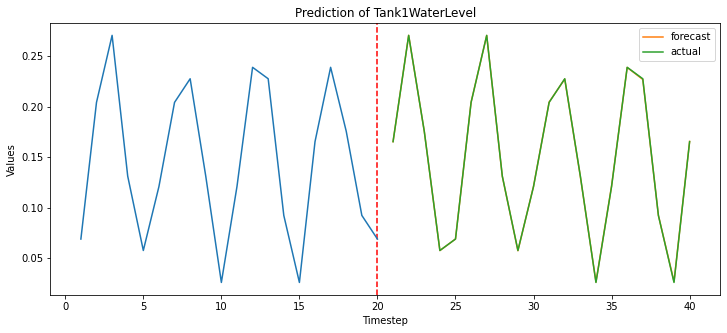

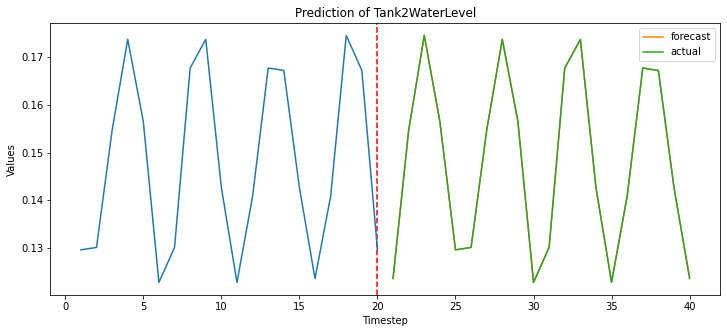

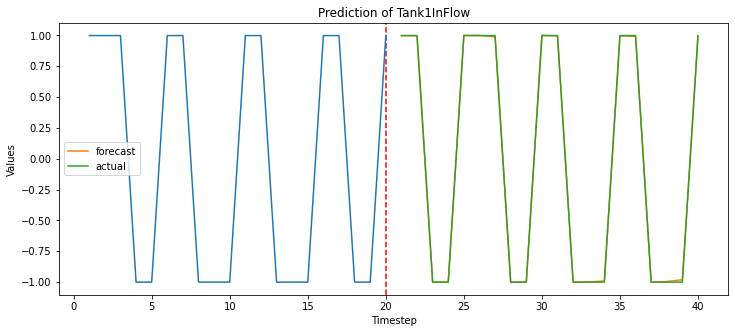

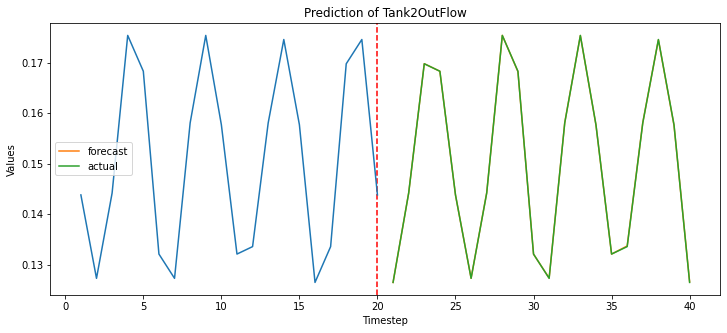

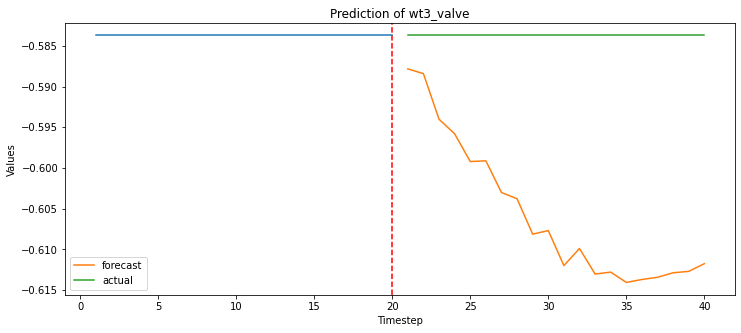

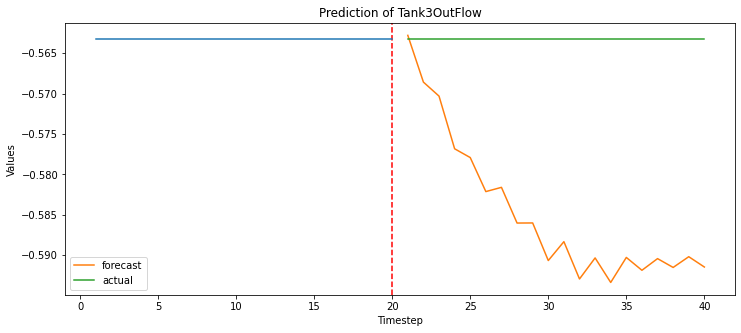

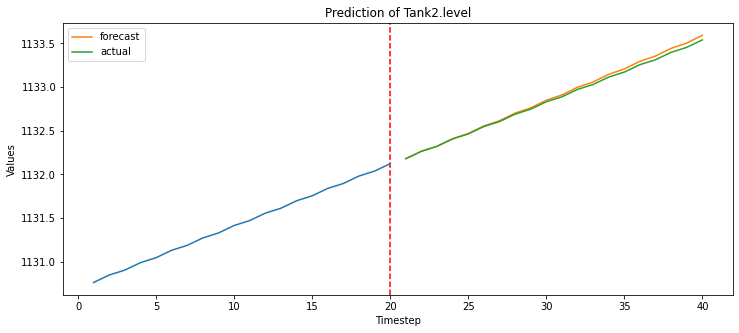

In [105]:
# attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# # attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
# for i in range(len(attr)):
#     title = "Prediction of {}".format(attr[i])
#     actual_index = pd.Index(list(range(lag_order)))
#     actual = train.iloc[-lag_order:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps)))
#     actual = actual.set_index(actual_index)
#     pred = df_forecast.set_index(index)
#     actual_test = test.iloc[:lag_order+1,:].set_index(index)
#     # draw a vertical line at x=19
#     plt.axvline(x=lag_order, ls='--', color='red')
# #     pred = df_forecast
#     plt.title(title)
#     plt.xlabel("Timestep")
#     plt.ylabel("Values")
#     plt.plot(actual.iloc[:,i])
#     plt.plot(pred.iloc[:,i], label="forecast")
#     plt.plot(actual_test.iloc[:,i], label="actual")
#     plt.legend()
#     plt.show()
    

    
attr = list(pd.read_csv('stuckAt0_training.csv').columns.values)[1:]
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
input_length = 20
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(1,input_length+1)))
#     actual = train.iloc[-lag_order:,:] # CORRECT BEFORE EDITING
    actual = train.iloc[-input_length:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps))) # CORRECT BEFORE EDITING
    index = pd.Index(list(range(input_length+1, input_length + steps +1)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:input_length,:].set_index(index)
    # draw a vertical line at x=20
#     plt.axvline(x=lag_order, ls='--', color='red') # CORRECT BEFORE EDITING
    plt.axvline(x=input_length, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

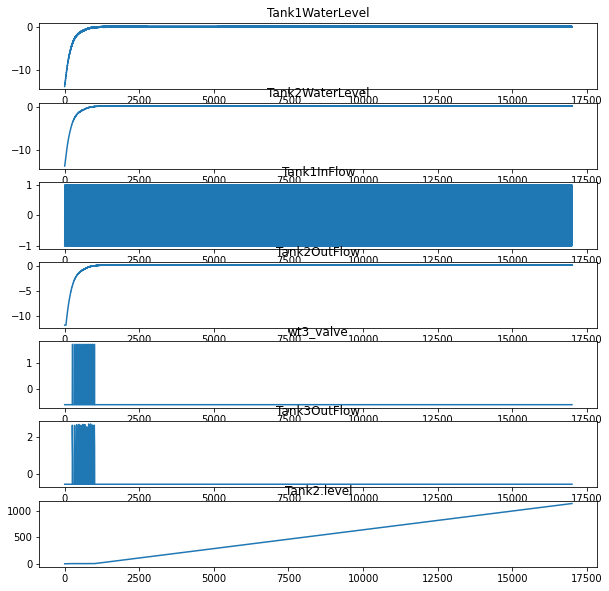

In [106]:
results.plot();

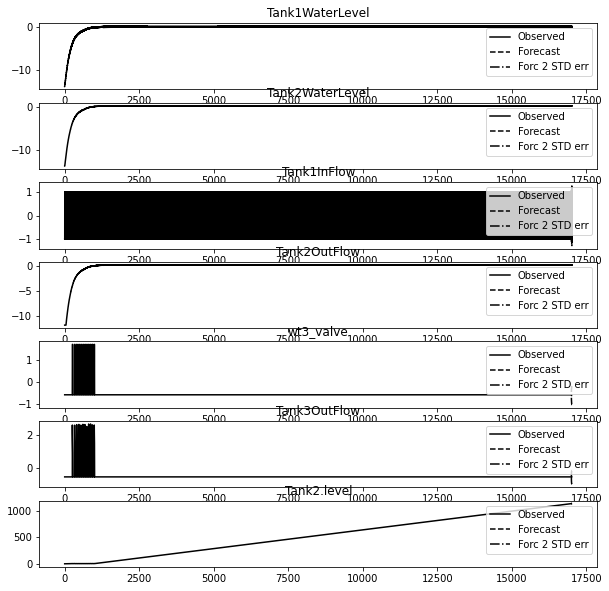

In [107]:
results.plot_forecast(20);

In [108]:
len(df_forecast)

20

In [109]:
len(df['Tank1WaterLevel'].iloc[:steps])

20

### Model Evaluation

In [110]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSE = []
for feat in attr:
    RMSE.append(rmse(pred[feat], actual_test[feat]))

print(RMSE)

[0.00035149351640983143, 7.351371170968237e-05, 0.005789552297051851, 6.70403081812092e-05, 0.02353535677847356, 0.02322263732824402, 0.027812427194819786]


### Normalised RMSE

### Save the model

In [111]:
# Serialize andsave the model

with open('var_ctrl_stuckat0_perm.pkl', 'wb') as f:
    pickle.dump(results, f)
print("Model saved!")

Model saved!


In [112]:
print("Stop execution here")
print(error)

Stop execution here


NameError: name 'error' is not defined

### Define the faulty data

In [ ]:
faulty_data = pd.read_csv('test_fault.csv', index_col=0, header=0, parse_dates=True)
faulty_data.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty = faulty_data.iloc[:-num_obs]
test_faulty = faulty_data.iloc[-num_obs:]
len(train_faulty), len(test_faulty)

### Load the model and reconstruct VAR

In [ ]:
with open('var_ctrl_stuckat0.pkl', 'rb') as f:
    params = pickle.load(f)
    
stuckat0_model = sm.tsa.VAR(train)
stuckat0_model.params = params
stuckat0_model_fit = stuckat0_model.fit(min_aic_index)

stuckat0_model_fit.summary()

### Forecast using faulty data

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast = stuckat0_model_fit.forecast(y=train_faulty.values[-lag_order:], steps=20)
# forecast = golden_model_fit.forecast(params, start=len(train), end=len(train)+10)
forecast

In [ ]:
fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

### Increasing the duration of faults

In [ ]:
faulty_data_extend = pd.read_csv('test_extend.csv', index_col=0, header=0, parse_dates=True)

faulty_data_extend.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty_extend = faulty_data_extend.iloc[:-num_obs]
test_faulty_extend = faulty_data_extend.iloc[-num_obs:]
len(train_faulty_extend), len(test_faulty_extend)

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast_extend = stuckat0_model_fit.forecast(y=train_faulty_extend.values[-lag_order:], steps=20)

In [ ]:
fault_forecast = pd.DataFrame(forecast_extend, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)